# Humoral sex

## Imports

In [1]:
import datetime
import os
from tqdm import tqdm
import h5py

import pandas as pd
import numpy as np

import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import confidenceinterval

import torch
from torch import nn
import torch.utils.data as data
import lightning as pl

from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
import matplotlib.font_manager as font_manager
import seaborn as sns

pingouin_available = False
statannotations_available = False

try:
    import pingouin as pg

    pingouin_available = True
    print("Using pingouin package for partial correlations")
except:
    pingouin_available = False

try:
    from statannotations.Annotator import Annotator

    statannotations_available = True
    print("Using statannotations package for boxplot star annotations")
except:
    statannotations_available = False

Using pingouin package for partial correlations
Using statannotations package for boxplot star annotations


## Define graphic parameters and declare functions used to plot figures

In [2]:
try:
    mpl.colormaps.unregister("mg_custom_cmap")
except:
    pass
mpl.colormaps.register(cmap=ListedColormap(["#eaecee", "#aed6f1", "#7393B3", "#17202a"], name="mg_custom_cmap"))

# graphical parameters, for article figures:
pp_size = 6
legend_font_params = font_manager.FontProperties(family='Calibri',
                                                 weight='normal',
                                                 style='normal',
                                                 size=24)
paneltitle_font_params = font_manager.FontProperties(family='Calibri',
                                                     weight='bold',
                                                     style='normal',
                                                     size=24)
labels_font_params = {"fontname": "Calibri", "fontweight": "normal", "fontsize": 24}
ticks_font_params = {'family': 'Calibri', 'weight': 'normal', 'size': 22}
scatter_plot_size = 120
boxplot_mean_marker_size = 10
boxplot_lw = 4.0
boxplot_precise_lw = 1.0
boxplot_props = {
    'flierprops': {"markersize": boxplot_mean_marker_size},
    'meanprops': {"marker": "X", "markeredgecolor": "#333333", "markerfacecolor": "#333333", "markersize": boxplot_mean_marker_size}}

rcParams['axes.facecolor'] = 'white'
# rcParams['axes.edgecolor'] = 'black'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Calibri:italic'
rcParams['mathtext.rm'] = 'Calibri'
rcParams['mathtext.bf'] = 'Calibri:bold'
rc_params = {'font.size': 16, }
plt.rcParams.update(rc_params)

# quick function to do regression plot
def plot_lm(x, y, group_name, xlabel, ylabel, xticks=None, yticks=None, show_grid: bool = True,
            correlation_method=("spearman", "pearson")[1],
            n_xticks: int = 7, n_yticks: int = 7, suptitle: str = None,
            scatter_plot_custom_size: float = scatter_plot_size, scatter_kws_custom_alpha: float = 0.5,
            text_show: bool = True, text_show_sample_size: bool = True, text_bbox_alpha: float = .0, text_pos: str = "top left",
            verticalalignment=None, horizontalalignment=None,
            common_scale: bool = False, no_lm: bool = False,
            console_print_pr: bool = False,
            confidence_level: float = None):
    from scipy import stats
    from sklearn.linear_model import LinearRegression

    x = x.to_numpy() if type(x) is pd.Series else x
    x = np.array(x) if type(x) in (list, tuple) else x
    y = y.to_numpy() if type(y) is pd.Series else y
    y = np.array(y) if type(y) in (list, tuple) else y
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xymin, xymax = min(x.min(), y.min()), max(x.max(), y.max())
    xyrange = xymax - xymin
    xrange, yrange = xmax - xmin, ymax - ymin
    if correlation_method == "pearson":
        # r, p = scipy.stats.pearsonr(x=x, y=y)
        cor_method = stats.pearsonr
    elif correlation_method == "spearman":
        # r, p = scipy.stats.spearmanr(a=x, b=y)
        cor_method = stats.spearmanr
    else:
        assert False, f"Unsupported {correlation_method=}"
    r, p = cor_method(x, y)
    if confidence_level is not None:
        assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
        bts_results = stats.bootstrap((x, y), cor_method, paired=True, n_resamples=9999, confidence_level=confidence_level, random_state=1)
        r_lo = bts_results.confidence_interval[0][0]
        r_hi = bts_results.confidence_interval[1][0]
    else:
        r_lo, r_hi = None, None

    lm = LinearRegression()
    lm.fit(X=x.reshape(-1, 1), y=y.reshape(-1, 1))
    # slope, intercept = lm.coef_[0][0], lm.intercept_[0]
    if common_scale:
        xmin, xmax, xrange, ymin, ymax, yrange = xymin, xymax, xyrange, xymin, xymax, xyrange
        ax = sns.lineplot(x=[0, xymax], y=[0, xymax], linestyle='--', color="#aaaaaa")
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            sns.scatterplot(x=x, y=y, **scatter_kws, ax=ax)
        else:
            sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"}, ax=ax)
    else:
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            ax = sns.scatterplot(x=x, y=y, **scatter_kws)
        else:
            ax = sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"})
    # reset ymin, max, etc. based on xticks yticks
    if (xticks is not None) and (len(xticks) > 0):
        xmin = min(xmin, min(xticks))
        xmax = max(xmax, max(xticks))
    if (yticks is not None) and (len(yticks) > 0):
        ymin = min(ymin, min(yticks))
        ymax = max(ymax, max(yticks))
    xrange = xmax - xmin
    yrange = ymax - ymin
    if text_pos.split(" ")[0] == "top":
        text_y = ymin + yrange * .98
        if verticalalignment is None:
            verticalalignment = "top"
    else:
        text_y = ymin + yrange * .02
        if verticalalignment is None:
            verticalalignment = "bottom"
    if text_pos.split(" ")[1] == "left":
        text_x = xmin + xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "left"
    else:
        text_x = xmax - xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "right"
    if text_show:
        if no_lm and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}'
        elif (not no_lm) and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}' + '\n' + r"$\it{r}$" + f' = {r:.2f}'
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        elif (not no_lm) and (not text_show_sample_size):
            lm_text = (r"$\it{r}$" + f' = {r:.2f}')
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        else:
            lm_text = ""
            text_show = False
        if text_show:
            plt.text(text_x, text_y,
                     # '\n' + '$\it{slope} = $' + f'{slope:.1f}' + ', $\it{intercept} = $' + f'{intercept:.1f}' +
                     lm_text,
                     verticalalignment=verticalalignment,
                     horizontalalignment=horizontalalignment,
                     font=legend_font_params,
                     bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)
    if common_scale:
        plt.xlim(xymin, xymax)
        plt.ylim(xymin, xymax)
    if xticks is not None:
        plt.xticks(xticks)
    else:
        plt.locator_params(axis='x', nbins=n_xticks)
    xticks = ax.get_xticks()
    if (xticks % 1 == 0).all():
        xticks = xticks.astype(int)
    round_yticks = False
    if yticks is not None:
        plt.yticks(yticks)
    else:
        round_yticks = True
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    elif round_yticks:
        # round intelligently
        n_decimalzeros = np.ceil(-np.log10((np.max(yticks) - np.min(yticks)) / 100))
        yticks = np.round(yticks, n_decimalzeros)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if show_grid:
        plt.grid(color='#aaaaaa', linewidth=0.5)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    if console_print_pr:
        print(f"r={r:.2f}, p={p:.1g}")
    return ax


# quick function to do regression
def plot_box(x, y, hue, xlabel, ylabel, yticks=None, n_yticks: int = 5, showmeans: bool = True, suptitle: str = None,
             legend_loc: str = None, legend_off: bool = False,
             data=None, palette=None,
             show_grid: bool = True,
             subtype="boxplot",
             swarmsize=None,
             display_n_obs=True,
             ax=None):
    # the actual box plot
    # ax = None
    if subtype == "boxplot":
        ax = sns.boxplot(data=data, x=x, y=y, hue=hue,
                         ax=ax,
                         palette=palette,
                         linewidth=boxplot_lw,
                         notch=False,
                         # saturation=1.,
                         **boxplot_props,
                         showmeans=showmeans)
    elif subtype == "violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot+swarmplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
        sns.swarmplot(data=data, x=x, y=y, hue=hue,
                      ax=ax,
                      dodge=True,
                      color="#999999",
                      alpha=.9,
                      # palette=palette,
                      size=1 if swarmsize is None else swarmsize,
                      )
    elif subtype == "stripplot":
        ax = sns.stripplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           palette=palette,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    elif subtype == "swarmplot":
        ax = sns.swarmplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           dodge=True,
                           palette=palette,
                           size=1,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    else:
        assert False, f"Unknown {subtype=}"
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # grid
    if show_grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='#aaaaaa', linewidth=0.5)
        # plt.grid(axis="y", color='#aaaaaa', linewidth=0.5)
    # display n
    if display_n_obs:
        # assert hue is None, "Cannot compute text for n_obs if hue is not None!"
        assert data is not None, "Cannot compute text for n_obs if data is None!"
        # medians = data.groupby([x])[y].median().values
        ylo, yhi = ax.get_ylim()
        y0pos = ylo + (yhi - ylo) * .01
        if hue is None:
            # nobs = boxplot_kwargs["data"][boxplot_kwargs["x"]].value_counts().values
            nobs = data[x].value_counts().values
            nobs = [str(x) for x in nobs.tolist()]
            nobs = ["n=" + i for i in nobs]
        else:
            nobs = []
            # for x_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["x"]].cat.categories):
            #     n_by_hue = []
            #     for hue_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["hue"]].cat.categories):
            #         n_here = ((boxplot_kwargs["data"][boxplot_kwargs["x"]] == x_possible_value) & (boxplot_kwargs["data"][boxplot_kwargs["hue"]] == hue_possible_value)).sum()
            #         n_by_hue.append(n_here)
            #     nobs.append(n_by_hue)
            for x_possible_value in list(data[x].cat.categories):
                n_by_hue = []
                for hue_possible_value in list(data[hue].cat.categories):
                    n_here = ((data[x] == x_possible_value) & (data[hue] == hue_possible_value)).sum()
                    n_by_hue.append(n_here)
                nobs.append(n_by_hue)
            nobs = [["n=" + str(x) for x in xlist] for xlist in nobs]

        pos = range(len(nobs))
        for tick, label in zip(pos, ax.get_xticklabels()):
            if type(nobs[tick]) is list:
                hueobs = nobs[tick]
                space_between_ticks = 1 / (len(hueobs) + 1)
                ticks_range = (len(hueobs) - 1) * space_between_ticks
                tick_start = 0 - (ticks_range / 2)
                for ti, nobs_hue in enumerate(hueobs):
                    ax.text(pos[tick] + tick_start + ti * space_between_ticks,
                            # medians[tick] + 0.03,
                            y0pos,
                            nobs_hue,
                            horizontalalignment='center',
                            size='x-small',
                            color='black', )
            else:
                ax.text(pos[tick],
                        # medians[tick] + 0.03,
                        y0pos,
                        nobs[tick],
                        horizontalalignment='center',
                        size='x-small',
                        color='black', )
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    return ax


def plot_roc(y, y_, suptitle: str = None, display_n: bool = False, text_bbox_alpha: float = .0, confidence_level: float = None):
    if confidence_level is not None:
        assert (confidence_level > 0) and (confidence_level < 1), f"Unexpected {confidence_level=}"

        t = np.concatenate([[np.Inf, ], np.sort(np.unique(y_))[::-1]])
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = [], [], [], [], [], []
        for thresh in t:
            thresh_tpr, (thresh_tpr_lo, thresh_tpr_hi) = confidenceinterval.tpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            thresh_fpr, (thresh_fpr_lo, thresh_fpr_hi) = confidenceinterval.fpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            tpr.append(thresh_tpr)
            tpr_lo.append(thresh_tpr_lo)
            tpr_hi.append(thresh_tpr_hi)
            fpr.append(thresh_fpr)
            fpr_lo.append(thresh_fpr_lo)
            fpr_hi.append(thresh_fpr_hi)
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = np.array(tpr), np.array(tpr_lo), np.array(tpr_hi), np.array(fpr), np.array(fpr_lo), np.array(fpr_hi)

        roc_auc, (roc_auc_lo, roc_auc_hi) = confidenceinterval.roc_auc_score(y, y_, confidence_level=confidence_level)

    else:
        # using sklearn
        from sklearn import metrics

        fpr, tpr, t = metrics.roc_curve(y, y_)
        tpr_lo, tpr_hi, fpr_lo, fpr_hi = None, None, None, None
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_lo, roc_auc_hi = None, None

    # confidenceinterval.roc_auc_score(y_true=balanced_df["Binary race"], y_pred=balanced_df[peak_method])

    # Plot curve
    plt.plot([0, 1], [0, 1], color='#aaaaaa', lw=2, linestyle='--')

    if confidence_level is not None:
        plt.fill_between(x=fpr, y1=tpr_lo, y2=tpr_hi, color='black', alpha=.1)
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f} ({roc_auc_lo:0.2f}-{roc_auc_hi:0.2f})')
    else:
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f}')

    if display_n:
        plt.text(.05, .95,
                 '$\it{n}$' + f' = {len(y)}',
                 verticalalignment="top",
                 horizontalalignment="left",
                 font=legend_font_params,
                 bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)

    # Set boundaries, labels, titles...
    plt.xlim([0., 1.])
    plt.ylim([0., 1.])

    ax = plt.gca()
    xticks = np.round(100 * ax.get_xticks(), 0).astype(int)
    yticks = np.round(100 * ax.get_yticks(), 0).astype(int)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)

    plt.xlabel('False Positive Rate', **labels_font_params)
    plt.ylabel('True Positive Rate', **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
        # plt.title(suptitle)
    plt.legend(loc="lower right")
    plt.tight_layout()
    return ax


# quick function to do regression
def plot_paired_box(data, x, y, xlabel, ylabel, yticks=None, n_yticks: int = 7, showmeans: bool = False, suptitle: str = None,
                    legend_loc: str = None, legend_off: bool = False, palette=None, points_palette=None):
    # the actual box plot
    ax = sns.boxplot(data=data, x=x, y=y,
                     palette=palette,
                     linewidth=boxplot_lw,
                     notch=False,
                     # saturation=1.,
                     **boxplot_props,
                     showmeans=showmeans)
    scatter_kws = {"alpha": 1.0, "s": scatter_plot_size}
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **scatter_kws, palette=points_palette, hue=x)
    x1, x2 = data[x].unique()
    for y1, y2 in zip(data[data[x] == x1][y].tolist(), data[data[x] == x2][y].tolist()):
        lcolor = "#ff0000" if y2 > y1 else "#0000ff"
        sns.lineplot(x=[x1, x2], y=[y1, y2], ax=ax, color=lcolor)
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    else:
        ax.legend_.remove()
    return ax

Set dataset path

In [3]:
for dropbox_path in [r"C:\Users\flori\Dropbox (Partners HealthCare)", r"C:\Users\f.chabrun\Partners HealthCare Dropbox\Floris Chabrun"]:
    if os.path.exists(dropbox_path):
        print(f"Found DROPBOX folder")
        checkpoint_path = os.path.join(dropbox_path, r"Floris\SPECTR-MS\out\checkpoints", r"v92_sex_v2\v2_base_batch_size_32",
                                       "epoch=12-step=3172.ckpt")
        dataset_dir = os.path.join(dropbox_path, 'Floris/SPECTR-MS/data/v9.0/dataset')
        break

Found DROPBOX folder


Set various parameters that will be used for deep learning analysis (e.g. input size, batch size, etc.)

In [4]:
input_dim = 1536
batch_size = 32
training_coarse_dropout = {
    "n_binom_n": 10,
    "n_binom_p": 0.5,
    "width_binom_n": 200,
    "width_binom_p": 0.5
}
prediction_target = "SEX"

Load dataset, and pre-process: filter out samples not passing QC, perform some statistics

In [5]:
dataset = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "dataset_final.h5"), key="dataset"))
dataset_backup = dataset.copy()
print(f"Loaded dataset with {dataset.shape=}")

dataset = dataset.loc[dataset.QC_MSRAW_Data_Available, :]
print(f"    > Filtered to {dataset.shape=} after removing missing/invalid MS data")
dataset = dataset.loc[~dataset.QC_MS_Noise_Filter_Triggered, :]
print(f"    > Filtered to {dataset.shape=} after removing noisy samples")

# remove patients with unavailable MS_DIAGNOSIS
filt = dataset.GLOBAL_DIAGNOSIS.isin(["Negative", "MGUS", "MGIP-High", "MGIP-Low", "LC-MGUS"])
print("dataset statistics:")
print("")
print(f"{len(dataset)=}")
print("")
print("dataset.COHORT2")
print(dataset.COHORT2.value_counts().to_string())
print("")
print("dataset.GLOBAL_DIAGNOSIS")
print(dataset.GLOBAL_DIAGNOSIS.value_counts().to_string())
print("")
print("Earliest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).min())
print("Latest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).max())
print("")
print("dataset.RACE")
print(dataset.RACE.value_counts().to_string())
print("")
print("dataset.SEX")
print(dataset.SEX.value_counts().to_string())
print("dataset.AGE")
print(np.nanquantile(dataset.AGE, [.25, .5, .75]))
print("")
print("dataset.ETHNIC_GROUP")
print(dataset.ETHNIC_GROUP.value_counts().to_string())

print(pd.crosstab(dataset.MS_DIAGNOSIS, dataset.GLOBAL_DIAGNOSIS).to_string())

# create the batch variable, using the plate barcode (barcodes are ordered, lowest = oldest batch, highest = latest batch)
plate_barcode_batch_dict = {plate_barcode: index + 1 for index, plate_barcode in
                            enumerate(dataset.PLATE_BARCODE_BATCH.astype(int).sort_values().unique())}

# check properly correlated
ordered_plate_barcodes = np.array([k for k, v in plate_barcode_batch_dict.items()])
ordered_batches = np.array([plate_barcode_batch_dict[k] for k in ordered_plate_barcodes])
assert (np.argsort(ordered_plate_barcodes) == np.arange(len(ordered_plate_barcodes))).all()
assert (np.argsort(ordered_batches) == np.arange(len(ordered_batches))).all()

# create the batch variable
dataset["Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).map(plate_barcode_batch_dict)

# also add "simplified batch", depending on the year the sample was analyzed
dataset["Simplified_Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).apply(
    lambda b: 1 if b < 22000000 else 2 if b < 22800000 else 3 if b < 24000000 else -1)


PRED_COL = "SEX"
POS_CLASS = "M"
NEG_CLASS = "F"

dataset = dataset.loc[dataset[PRED_COL].isin([POS_CLASS, NEG_CLASS]), :]

print(f"After removing NA/extreme/unkept values, {dataset.shape=}")

negative_training_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["Negative", ]) &
                            dataset.COHORT.isin(["MGB", "PROMISE_USA", "PROMISE_SA", "PROMISE_SERIAL", ]))
# only negative AND in a screening cohort

positive_leftout_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["MGIP-Low", "MGIP-High", "LC-MGUS", "MGUS"]))
# regardless of the cohort

dataset_intraining = dataset.loc[negative_training_filter, :]  # negative; may have peaks <LLMI, but will have normal FLCr (not pathological)
dataset_outtraining = dataset.loc[positive_leftout_filter, :]  # mgip group, mgus group, LC-MGUS group

print(f"Training (based on MS Diagnosis): {dataset_intraining.shape=}")
if dataset_outtraining is not None:
    print(f"Out of training (based on MS Diagnosis): {dataset_outtraining.shape=}")

x_intraining = dataset_intraining.ANON_ID.tolist()
y_intraining = np.stack([((dataset_intraining[PRED_COL] == NEG_CLASS) * 1).to_numpy(),
                         ((dataset_intraining[PRED_COL] == POS_CLASS) * 1).to_numpy()], axis=-1)
x_outtraining = dataset_outtraining.ANON_ID.tolist()
y_outtraining = np.stack([((dataset_outtraining[PRED_COL] == NEG_CLASS) * 1).to_numpy(),
                          ((dataset_outtraining[PRED_COL] == POS_CLASS) * 1).to_numpy()], axis=-1)

assert (y_intraining.sum(axis=1) == 1).all(), "Some samples do not have y value?"
assert (y_outtraining.sum(axis=1) == 1).all(), "Some samples do not have y value?"

assert np.isfinite(y_intraining).all(), f"Some values in the y array are not finite"

x = x_intraining
y = y_intraining

y_stratify = None


spectrum_files_with_annotations = x
spectrum_annotations_matching = y
spectrum_stratify = y_stratify

print(f"Found {len(spectrum_files_with_annotations)=} labeled samples for supervised training")

Loaded dataset with dataset.shape=(18115, 39)
    > Filtered to dataset.shape=(18052, 39) after removing missing/invalid MS data
    > Filtered to dataset.shape=(17151, 39) after removing noisy samples
dataset statistics:

len(dataset)=17151

dataset.COHORT2
COHORT2
mgb1.0              5318
PSCR_USA            3997
PLCO_MM_NIH1.0      2225
PRM_South_Africa    1985
mgb2.0              1956
PCROWD               726
PRES                 337
PFOL                 274
PSCR                 117
SU2C                  90
nan                   85
PROMISE_PRES          35
MGIP_exp               6

dataset.GLOBAL_DIAGNOSIS
GLOBAL_DIAGNOSIS
Negative               9214
MGUS                   3947
MGIP-High              1783
MGIP-Low               1657
LC-MGUS                 446
nan                      85
MG_not_quantifiable      17
Failure                   2

Earliest date: 2010-07-28 00:00:00
Latest date: 2024-03-01 00:00:00

dataset.RACE
RACE
White                     9684
Black                 

The raw mass spectrometry data (spectra) are stored in a separate dataset
Below we are going to define the functions that can be used to load the spectra from the anonymization IDs listed in the dataset

In [6]:
def load_sample_ms_data(dataset_path: str, match_id: str, peak_removal_method=None):
    if (peak_removal_method is None) or (type(peak_removal_method) in (list, tuple)):  # load raw ms data
        ms_fn = "ms_data.h5"
    else:  # load ms data already preprocessed (peaks dropped out or smoothed)
        ms_fn = f"ms_data_{peak_removal_method}_nopeaks.h5"
    with h5py.File(os.path.join(dataset_path, ms_fn), 'r') as hf:
        x = np.array(hf[match_id])
    if type(peak_removal_method) in (list, tuple):  # manually dropout according to some peaks location information
        for peak_info in peak_removal_method:
            peak_map = (x[0, peak_info["track"], :] >= peak_info["mz_start"]) & (x[0, peak_info["track"], :] <= peak_info["mz_end"])  # locate peak are
            x[1, peak_info["track"], peak_map] = 0  # dropout area
    return x


def _auto_reshape_x(x: np.array, input_dim: int, max_random: int = 0) -> np.array:
    dim = x.shape[-1]
    # handle dim
    if dim < input_dim:
        total_padding = input_dim - dim
        padding_left = total_padding // 2
        if max_random > 0:
            padding_left = np.random.randint(low=max(0, padding_left - max_random), high=min(total_padding, padding_left + max_random) + 1)
        padding_right = total_padding - padding_left
        return np.concatenate([np.tile(x[:, [0]], reps=padding_left), x, np.tile(x[:, [-1]], reps=padding_right)], axis=-1)
    elif dim > input_dim:
        total_remove = dim - input_dim
        remove_left = total_remove // 2
        if max_random > 0:
            # adjust start of the input data by random value
            # min and max would be default pos value +/- max random allowed, clipped to 0/(dim-input_dim)
            remove_left = np.random.randint(low=max(0, remove_left - max_random), high=min(total_remove, remove_left + max_random) + 1)
        return x[:, remove_left:(remove_left + input_dim)]
    return x


class MSSpectraDataset(data.Dataset):
    def __init__(self, dataset_path, sample_match_ids, input_dim, sample_annotations=None,
                 coarse_dropout_parameters=None, peak_removal_method=None, random_crop=0, make_segmentation_maps=False):
        self.dataset_path = dataset_path
        self.sample_match_ids = sample_match_ids
        self.sample_annotations = sample_annotations
        self.input_dim = input_dim
        self.buffered_data = None
        self.coarse_dropout_parameters = coarse_dropout_parameters
        self.peak_removal_method = peak_removal_method
        self.random_crop = random_crop
        self.make_segmentation_maps = make_segmentation_maps

    def __len__(self):
        return len(self.sample_match_ids)

    def __getitem__(self, idx):
        if self.buffered_data is not None:
            return self.buffered_data[idx]
        if (self.peak_removal_method is None) or type(self.peak_removal_method) is str:
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method)
        elif type(self.peak_removal_method) in (list, tuple):
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method[idx])
        y = None if self.sample_annotations is None else self.sample_annotations[idx]
        if len(x.shape) == 3:
            x = x[1, ...]
        x = _auto_reshape_x(x=x, input_dim=self.input_dim, max_random=self.random_crop)
        # normalize
        xmin = x.min(axis=1, keepdims=True)
        xmax = x.max(axis=1, keepdims=True)
        x = (x - xmin) / (xmax - xmin)
        # random coarse dropouts
        if self.coarse_dropout_parameters is not None:
            cd_params = self.coarse_dropout_parameters
            n_coarse_dropouts = np.random.binomial(cd_params["n_binom_n"], cd_params["n_binom_p"])
            if n_coarse_dropouts > 0:
                # randomly determine dropouts location, size and track
                coarse_dropouts_width = np.random.binomial(cd_params["width_binom_n"], cd_params["width_binom_p"], n_coarse_dropouts)
                coarse_dropouts_track = np.random.uniform(0, 5, n_coarse_dropouts).astype(int)
                coarse_dropouts_center = [np.random.choice(x.shape[-1], p=x[track] / x[track].sum()) for track in coarse_dropouts_track]
                # apply
                for coarse_loc, coarse_width, coarse_track in zip(coarse_dropouts_center, coarse_dropouts_width, coarse_dropouts_track):
                    x[coarse_track, (coarse_loc - coarse_width):(coarse_loc + coarse_width)] = 0
        # reshape
        x = x.reshape((5, 1, self.input_dim))
        # turn to tensor
        x = torch.as_tensor(x, dtype=torch.float32)
        if y is not None:
            return x, y
        return x,

Then we can create our datasets, after separating training and validation samples

In [7]:
spectrum_files_train, spectrum_files_test, spectrum_annotations_train, spectrum_annotations_test = train_test_split(spectrum_files_with_annotations,
                                                                                                                    spectrum_annotations_matching,
                                                                                                                    test_size=.1,
                                                                                                                    random_state=1, shuffle=True,
                                                                                                                    stratify=y_stratify)

train_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                 sample_match_ids=spectrum_files_train,
                                 sample_annotations=spectrum_annotations_train.astype(np.float32),
                                 input_dim=input_dim,
                                 random_crop=20,
                                 coarse_dropout_parameters=training_coarse_dropout)

test_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                sample_match_ids=spectrum_files_test,
                                sample_annotations=spectrum_annotations_test.astype(np.float32),
                                input_dim=input_dim)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

validation_loader = data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

## Deep learning pipeline

In [8]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss
    

def _get_homemade_encoder_v1_base_modules(input_dim, input_channels, encoder_blocks_layout, maxpool, kernel_size, stride, dropout,
                                          first_layer_groups, groups, batchnorm, hidden_activation, flatten):

    assert (maxpool == 1 and stride > 1) or (maxpool > 1 and stride == 1), f"Exactly one of {maxpool=} and {stride=} must be > 1"
    n_pools = len(encoder_blocks_layout) - 1 if maxpool > 1 else len(encoder_blocks_layout)

    _encoder_modules = []

    previous_channels = input_channels

    for block_position, block_layers in enumerate(encoder_blocks_layout):
        if block_position > 0:
            if maxpool > 1:
                _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, maxpool), stride=(1, maxpool)))
        for layer_position, layer_channels in enumerate(block_layers):
            current_stride = stride if layer_position == 0 else 1
            padding = 0
            if current_stride > 1:
                hin = input_dim // (max(maxpool, stride) ** (layer_position))
                padding = (kernel_size - hin + stride * (hin / stride - 1)) / 2
                assert (padding % 1) == 0, f"Current {stride}, {hin=} and {kernel_size=} end with decimal {padding=}"
                padding = int(padding)

            _encoder_modules.append(nn.Conv2d(in_channels=previous_channels, out_channels=layer_channels, kernel_size=(1, kernel_size),
                                              stride=(1, current_stride),
                                              groups=first_layer_groups if ((layer_position == 0) and (block_position == 0)) else groups,
                                              padding=(0, padding) if current_stride > 1 else "same"))
            if (dropout is not None) and (dropout > 0):
                _encoder_modules.append(nn.Dropout(p=dropout))
            previous_channels = layer_channels
            if batchnorm:
                _encoder_modules.append(nn.BatchNorm2d(layer_channels))
            if hidden_activation == "relu":
                _encoder_modules.append(nn.ReLU())
            elif hidden_activation == "leaky_relu":
                _encoder_modules.append(nn.LeakyReLU())
            elif hidden_activation == "elu":
                _encoder_modules.append(nn.ELU())
            elif hidden_activation == "selu":
                _encoder_modules.append(nn.SELU())
            else:
                assert False, f"Unknown {hidden_activation=}"

    encoder_lastconv_dim = input_dim // (max(stride, maxpool) ** n_pools)
    encoder_lastconv_channels = encoder_blocks_layout[-1][-1]

    if flatten == "avg":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.AvgPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "max":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "flatten":
        encoder_output_dim = encoder_lastconv_channels * encoder_lastconv_dim
        _encoder_modules.append(nn.Flatten())
    else:
        assert False, f"Unknown {flatten=}"

    return _encoder_modules, encoder_output_dim  # , encoder_lastconv_channels, encoder_lastconv_dim


def _get_dense_encoder(input_dim, input_channels, encoder_blocks_layout, dropout, batchnorm, hidden_activation):

    _encoder_modules = []

    previous_size = input_dim * input_channels

    _encoder_modules.append(nn.Flatten())

    for layer_position, layer_size in enumerate(encoder_blocks_layout):

        _encoder_modules.append(nn.Linear(previous_size, layer_size))

        if (dropout is not None) and (dropout > 0):
            _encoder_modules.append(nn.Dropout(p=dropout))
        previous_size = layer_size
        if batchnorm:
            _encoder_modules.append(nn.BatchNorm1d(layer_size))
        if hidden_activation == "relu":
            _encoder_modules.append(nn.ReLU())
        elif hidden_activation == "leaky_relu":
            _encoder_modules.append(nn.LeakyReLU())
        elif hidden_activation == "elu":
            _encoder_modules.append(nn.ELU())
        elif hidden_activation == "selu":
            _encoder_modules.append(nn.SELU())
        else:
            assert False, f"Unknown {hidden_activation=}"

    return _encoder_modules, previous_size



class SupervisedModule(pl.LightningModule):
    def __init__(self, n_classes, mode,
                 input_dim, input_channels, latent_dim, kernel_size, flatten, stride, dropout, groups, first_layer_groups, maxpool,
                 encoder_blocks_layout, backbone, batchnorm, hidden_activation,
                 optimizer,
                 lr, lr_scheduler, lr_reduceonplateau_factor, lr_reduceonplateau_patience, lr_reduceonplateau_threshold, lr_reduceonplateau_minlr,
                 lr_multistep_milestones,
                 lr_multistep_gamma,
                 ):
        super().__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes
        self.mode = mode
        self.backbone = backbone

        if self.backbone == "resnet1d":
            from resnet1d.resnet1d import ResNet1D
            self.encoder = ResNet1D(in_channels=input_channels,
                                    base_filters=encoder_blocks_layout[0][0],
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    groups=groups,
                                    n_block=len(encoder_blocks_layout),
                                    n_classes=n_classes)

        elif self.backbone == "net1d":
            from resnet1d.net1d import Net1D
            self.encoder = Net1D(
                in_channels=input_channels,
                base_filters=encoder_blocks_layout[0][0],
                ratio=1.0,
                filter_list=[f[0] for f in encoder_blocks_layout],
                m_blocks_list=[len(f) for f in encoder_blocks_layout],
                kernel_size=kernel_size,
                stride=stride,
                groups_width=groups,
                verbose=False,
                n_classes=n_classes)

        elif (self.backbone == "conv") or (self.backbone == "homemade"):  # conv model was the first model designed, hence homemade
            encoder_modules, enc_out_dim = _get_homemade_encoder_v1_base_modules(input_dim=input_dim, input_channels=input_channels, maxpool=maxpool,
                                                                                 encoder_blocks_layout=encoder_blocks_layout, kernel_size=kernel_size,
                                                                                 stride=stride, dropout=dropout,
                                                                                 first_layer_groups=first_layer_groups, groups=groups,
                                                                                 batchnorm=batchnorm, hidden_activation=hidden_activation, flatten=flatten)
            self.encoder = nn.Sequential(*encoder_modules)
            self.fc = nn.Linear(enc_out_dim, latent_dim)
            self.pred = nn.Linear(latent_dim, self.n_classes)

        elif self.backbone == "dense":
            encoder_modules, enc_out_dim = _get_dense_encoder(input_dim=input_dim, input_channels=input_channels, encoder_blocks_layout=encoder_blocks_layout,
                                                              dropout=dropout, batchnorm=batchnorm, hidden_activation=hidden_activation)
            self.encoder = nn.Sequential(*encoder_modules)
            # self.fc = nn.Linear(enc_out_dim, latent_dim)
            # self.pred = nn.Linear(latent_dim, self.n_classes)
            self.pred = nn.Linear(enc_out_dim, self.n_classes)
        elif self.backbone == "vit_1d":
            from vit_pytorch import vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // defaults 0.1

            vit = vit_1d.ViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        elif self.backbone == "simple_vit_1d":
            from vit_pytorch import simple_vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = simple_vit_1d.SimpleViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
            )

            self.encoder = vit

        elif self.backbone == "smalldataset_vit_1d":
            from python.pyms_assets.vit_1d_for_small_dataset import SDViT

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = SDViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        else:
            assert False, f"Unknown {backbone=}"

        self.softmax = nn.Softmax(dim=1)

        if self.mode == "quant":
            self.loss = RMSELoss()
        if self.mode == "qual":
            self.loss = nn.CrossEntropyLoss()

        self.y_true = []
        self.y_pred = []

    def configure_optimizers(self):
        if self.hparams.optimizer == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "AdamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "RMSProp":
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.lr)
        else:
            assert False, f"Unknown {self.hparams.optimizer=}"
        if self.hparams.lr_scheduler == "reduceonplateau":
            print(
                f"Setting optimizer to reduceonplateau with params {self.hparams.lr_reduceonplateau_factor=}, {self.hparams.lr_reduceonplateau_patience=}, {self.hparams.lr_reduceonplateau_threshold=}, {self.hparams.lr_reduceonplateau_minlr=}")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.hparams.lr_reduceonplateau_factor,
                                                                   patience=self.hparams.lr_reduceonplateau_patience,
                                                                   threshold=self.hparams.lr_reduceonplateau_threshold,
                                                                   min_lr=self.hparams.lr_reduceonplateau_minlr, verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        elif self.hparams.lr_scheduler == "multistep":
            print(f"Setting optimizer to multistep with params {self.hparams.lr_multistep_milestones=}, {self.hparams.lr_multistep_gamma=}")
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.hparams.lr_multistep_milestones, gamma=self.hparams.lr_multistep_gamma,
                                                             verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        elif self.hparams.lr_scheduler != "none":
            assert False, f"Unknown {self.hparams.lr_scheduler=}"
        return optimizer

    def forward(self, batch):
        if type(batch) in (tuple, list):
            x, y = batch
        else:
            x = batch
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            x = self.encoder(x)
        elif self.backbone == "homemade":
            x = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            x = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            x = self.encoder(x)
        if self.mode == "qual":
            x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # encode x to get the mu and variance parameters
        yhat = None
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            yhat = self.encoder(x)
        elif self.backbone == "homemade":
            yhat = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            yhat = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            yhat = self.encoder(x)

        loss = self.loss(yhat, y)

        self.log_dict({
            'loss': loss,
        })

        return loss

Now we can load the deep learning model and pytorch/lightning objects needed to run the DL pipeline

In [9]:
trainer_args = {'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
                'devices': 'auto',
                'num_nodes': 1,
                'strategy': 'auto'}

pl.seed_everything(44)  # To be reproducible
model = SupervisedModule.load_from_checkpoint(checkpoint_path)

print(model)

trainer = pl.Trainer(
    # default_root_dir=os.path.split(checkpoint_path)[0],
    **trainer_args,
    callbacks=None,
    logger=None,
)

Seed set to 44
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


SupervisedModule(
  (encoder): Sequential(
    (0): Conv2d(5, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (1): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Conv2d(65, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (4): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(65, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (8): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU()
    (10): Conv2d(130, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (11): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SELU()
    (13): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (14):

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Then we can define the parameters that we will use to define what predictions we will realized and how we will analyze them
Here, we want to predict Sex, so we will focus on comparing with ground truth annotation

In [10]:
# parameters specific for race_v2 validation
ANALYSIS_TYPE = "QUALITATIVE"
UNSTANDARDIZE_PREDICTIONS = False
UNSTANDARDIZE_TRUES = False
OUTPUT_COLUMN_LOC = 0
TRUES_COLNAME = "Sex"
PREDS_COLNAME = "Sex score"
SAFETYCHECK_COLNAME = "SEX_Binary"

PAIR_APPROACHES = [
    "AGE_RACE_ETHNICITY_SIMPBATCH_MG_BY_SEX",
    # "AGE_RACE_ETHNICITY_SIMPBATCH_HEALTHYONLY_BY_SEX",
]

peak_method_2_label = {"Sex score": "Predicted female probability",
                       "Sex score (peaks dropped out)": "Predicted female probability (masked peaks)",
                       "Sex score (peaks smoothed)": "Predicted female probability (smoothed peaks)"}
peak_method_ticks = [0., .5, 1.]

Then, we will define a `supervised_inference` function which will help with automatically obtaining predictions from the model and converting those predictions into usable data for validation
Particularly, this function will be responsible of outputing raw predictions and predictions after masking peaks (peak dropout)
Furthermore, this function will be responsible of unstandardizing the target (y) variable, since age was standardized before training the model

In [11]:
def supervised_inference(sample_match_ids: list, sample_annotations: np.array,
                         negative_dropout_preprocess_data, output_column_loc: int,
                         unstandardize: bool, return_datasets_instead: bool = False, multi_preprocessing: bool = True):
    assert type(sample_match_ids) is list, f"{type(sample_match_ids)=}, must be a list"

    all_preds = []
    all_datasets = []

    if multi_preprocessing:
        if negative_dropout_preprocess_data is not None:
            preprocessings = [None, negative_dropout_preprocess_data]
        else:
            preprocessings = [None, "dropout"]
    else:
        preprocessings = [None, ]

    for preprocessing in preprocessings:
        the_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                       sample_match_ids=sample_match_ids,
                                       sample_annotations=sample_annotations,
                                       peak_removal_method=preprocessing,
                                       input_dim=input_dim)

        if return_datasets_instead:
            all_datasets.append(the_dataset)
            continue

        the_loader = data.DataLoader(
            the_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=0,
            persistent_workers=False
        )

        the_outputs = trainer.predict(model, dataloaders=the_loader)
        the_preds = torch.cat(the_outputs).detach().cpu().numpy()
        if output_column_loc is not None:
            the_preds = the_preds[:, output_column_loc]

        # save
        all_preds.append(the_preds)

    if return_datasets_instead:
        return all_datasets

    return all_preds

def find_paired_dropout_data(target_match_ids, positive_match_ids_to_pair, take_original_for_non_negatives_targets: bool):
    # 1) get the ages of the patients
    find_age_df_negatives = pd.DataFrame({"ANON_ID": target_match_ids}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_negatives) == len(target_match_ids)
    find_age_df_positives = pd.DataFrame({"ANON_ID": positive_match_ids_to_pair}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_positives) == len(positive_match_ids_to_pair)
    # remove LC-MGUS (no peaks)
    find_age_df_positives = find_age_df_positives[find_age_df_positives.GLOBAL_DIAGNOSIS != "LC-MGUS"]
    # now randomly pair each negative with a positive with same age
    # to do this, we can just merge both by rounded age
    find_age_df_negatives = find_age_df_negatives.rename(
        columns={"ANON_ID": "Negative_ANON_ID", "GLOBAL_DIAGNOSIS": "Negative_GLOBAL_DIAGNOSIS"})
    find_age_df_positives = find_age_df_positives.rename(
        columns={"ANON_ID": "Positive_ANON_ID", "GLOBAL_DIAGNOSIS": "Positive_GLOBAL_DIAGNOSIS"})
    find_age_df_negatives["Rounded_Age"] = find_age_df_negatives.AGE.round(0)
    find_age_df_positives["Rounded_Age"] = find_age_df_positives.AGE.round(0)
    all_possible_negpos_pairs = find_age_df_negatives.merge(find_age_df_positives, on="Rounded_Age", how="left")
    # now we can just shuffle our dataset randomly, and then remove duplicated Negative_ANON_ID to keep only 1 match per patient
    random_order = np.random.RandomState(seed=1).choice(np.arange(len(all_possible_negpos_pairs)), size=len(all_possible_negpos_pairs),
                                                        replace=False)
    all_possible_negpos_pairs = all_possible_negpos_pairs.iloc[random_order]
    paired_negative_samples = all_possible_negpos_pairs[~all_possible_negpos_pairs.Negative_ANON_ID.duplicated()]
    # finally re-order by merging with our initial negative samples list
    final_pair_df = find_age_df_negatives[["Negative_ANON_ID", "Negative_GLOBAL_DIAGNOSIS"]].merge(
        paired_negative_samples[["Negative_ANON_ID", "Positive_ANON_ID", "Positive_GLOBAL_DIAGNOSIS"]],
        on="Negative_ANON_ID", how="left")
    # now we just have to load the data that will be used for dropping out parts
    peaks_info_df = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "peaks_positions.h5")))
    paired_peaks_info = []
    # note: we are not using the type of pos diagnosis to decide which sample to pair
    # because since we are using ALL positives
    # we can say that the dropout will be make according to how frequent some peaks are seen in the whole population
    for idx in tqdm(range(len(final_pair_df))):
        if take_original_for_non_negatives_targets and (final_pair_df.iloc[idx]["Negative_GLOBAL_DIAGNOSIS"] != "Negative"):
            # we want to take the original peaks_info for non-negative samples
            # and this sample is not a negative
            # so we'll take its info instead of a matched positive
            selected_match_id = final_pair_df.iloc[idx].Negative_ANON_ID
        else:
            # this sample is a negative so has no peaks info (except potentially <LLMI/C1q)
            # or we set take_original_for_non_negatives to False to force taking the paired positive sample's peak info
            # any case, we'll "overwrite" this sample's peak info by the paired positive's
            selected_match_id = final_pair_df.iloc[idx].Positive_ANON_ID
        match_peaks_info = peaks_info_df[peaks_info_df.match_id == selected_match_id]
        match_peaks_info = [match_peaks_info.iloc[k].to_dict() for k in range(len(match_peaks_info))]
        paired_peaks_info.append(match_peaks_info)
    # now we can call our dataset
    (np.array([len(p) for p in paired_peaks_info]) > 0).sum()  # 876
    (np.array([len(p) for p in
               paired_peaks_info]) == 0).sum()  # 13  # sometimes there may be "0" peaks... it's rare and when the peak is 0.015 g/L, but flagged as LLMI (really in between)
    # return
    return paired_peaks_info


Then, we can create our different datasets (training set, validation set for negative samples, validation set for samples with monoclonal gammopathy) and compute model predictions

In [12]:
dataset_intraining = dataset_intraining.copy()
dataset_intraining[TRUES_COLNAME] = dataset_intraining.AGE

# COMMON FOR ALL: GET PREDICTIONS, GROUND TRUTHS, ETC.

# run all predictions
# predict humoral age/other things for negative samples
training_match_ids, training_trues = spectrum_files_train, spectrum_annotations_train
negative_match_ids, negative_trues = spectrum_files_test, spectrum_annotations_test
positive_match_ids, positive_trues = x_outtraining, y_outtraining

training_trues = training_trues[:, OUTPUT_COLUMN_LOC] if len(training_trues.shape) == 2 else training_trues
negative_trues = negative_trues[:, OUTPUT_COLUMN_LOC] if len(negative_trues.shape) == 2 else negative_trues
positive_trues = positive_trues[:, OUTPUT_COLUMN_LOC] if len(positive_trues.shape) == 2 else positive_trues

training_preds, = supervised_inference(sample_match_ids=training_match_ids,
                                       sample_annotations=training_trues,
                                       output_column_loc=OUTPUT_COLUMN_LOC,
                                       negative_dropout_preprocess_data=None,  # no need to dropout: comparing only negatives
                                       unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                       multi_preprocessing=False)

negative_preds, negative_preds_dropout = supervised_inference(sample_match_ids=negative_match_ids,
                                                              sample_annotations=negative_trues,
                                                              output_column_loc=OUTPUT_COLUMN_LOC,
                                                              negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                  target_match_ids=negative_match_ids,
                                                                  positive_match_ids_to_pair=positive_match_ids,
                                                                  take_original_for_non_negatives_targets=False),
                                                              unstandardize=UNSTANDARDIZE_PREDICTIONS)

# same for positives
positive_preds, dropoutpeaks_positive_preds = supervised_inference(sample_match_ids=positive_match_ids,
                                                                   sample_annotations=positive_trues,
                                                                   output_column_loc=OUTPUT_COLUMN_LOC,
                                                                   negative_dropout_preprocess_data=None,
                                                                   unstandardize=UNSTANDARDIZE_PREDICTIONS)

# for negatives, we also want to use dropout to compare results consistently with positives
# but they do not have peaks (by definition...)
# so instead we will pair each negative sample with one positive sample from the positive set
# (pairing will be made by age)
# and then we will mask them how we masked the positive samples

# PLOT DROPOUT EXAMPLES => FIGURE S11, FIGURE S1

# do small figures of how we dropout negative samples (once is enough for all models)
debug_paired_peaks_info = find_paired_dropout_data(target_match_ids=negative_match_ids,
                                                   positive_match_ids_to_pair=positive_match_ids,
                                                   take_original_for_non_negatives_targets=False)
nodropout_negative_dataset, dropout_negative_dataset = supervised_inference(sample_match_ids=negative_match_ids,
                                                                            sample_annotations=negative_trues,
                                                                            output_column_loc=OUTPUT_COLUMN_LOC,
                                                                            negative_dropout_preprocess_data=debug_paired_peaks_info,
                                                                            unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                                                            return_datasets_instead=True)
nodropout_positive_dataset, dropout_positive_dataset = supervised_inference(
    sample_match_ids=positive_match_ids,
    sample_annotations=positive_trues,
    output_column_loc=OUTPUT_COLUMN_LOC,
    negative_dropout_preprocess_data=None,
    unstandardize=UNSTANDARDIZE_PREDICTIONS,
    return_datasets_instead=True)


You are using a CUDA device ('NVIDIA RTX A5500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 245/245 [00:14<00:00, 16.86it/s]


100%|██████████| 869/869 [00:01<00:00, 839.31it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 16.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 31.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 241/241 [00:10<00:00, 22.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 241/241 [00:14<00:00, 16.34it/s]


100%|██████████| 869/869 [00:00<00:00, 962.39it/s]


## Validation

Here we will focus on comparing the predicted sex to the ground truth sex of patients

Create various functions required to analyze results; see BiAge jupyter notebooks for further explanations

To perform this, we will first declare a `create_balanced_df` function that will allow us to create a balanced dataset after matching 1:1 patients according to the selected criteria

In [13]:
def create_balanced_df(full_df: pd.DataFrame,
                       group_column,
                       pair_columns):
    """
    creates a balanced df out of a full df

    :param full_df: the original DF
    :param group_column: which column will be used to make groups, i.e. groups we want to compare
    :param pair_columns: which columns will be used for pairing, i.e. we want to have the same distribution for all those pair columns for each group that exists in our final cohort
    :return:
    """
    # group_column = {"name": "Group", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]}
    # pair_columns = [{"name": "Simplified_Batch", "values": []},
    #                 {"name": "RACE", "values": ["Black", "White"]},
    #                 {"name": "SEX", "values": ["F", "M"]},
    #                 {"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]},
    #                 {"name": "Age_rounded", "values": []}]

    full_df = full_df.copy()

    for coldata in [group_column, *pair_columns]:
        if len(coldata["values"]) > 0:
            full_df = full_df[full_df[coldata["name"]].isin(coldata["values"])]

    # to make the code lighter
    group_colname = group_column["name"]
    groups = full_df[group_colname].unique().tolist()
    n_groups = len(groups)

    # create a "pair label", i.e. a patient can be "black_female_61yo"
    full_df["Pair_Label"] = full_df[[m["name"] for m in pair_columns]].apply(concat_cols, axis=1)

    # group by both group and pair label, i.e. how many "black_female_61yo" in the "negative" vs "mgip" vs "mgus" groups
    group_results = full_df.groupby([group_colname, "Pair_Label"])["ANON_ID"].count().reset_index()

    # now we can determine which labels may be productive, we want to keep only labels for which all groups are represented
    group_results = group_results[group_results.groupby("Pair_Label")["ANON_ID"].transform("count") == n_groups]
    # now we can know how many samples we'll keep for each label: the minimum per group
    # e.g. if we have for the same pair label: 1 MGUS, 3 negs, 18 MGIP, we want to keep 1 of each so the groups are balanced
    group_results = group_results.groupby("Pair_Label")["ANON_ID"].min().reset_index()

    # finally we can create our balanced df

    pre_balanced_df = []
    for group in groups:
        for label, n in zip(group_results.Pair_Label, group_results.ANON_ID):
            subset = full_df[(full_df.Pair_Label == label) & (full_df[group_colname] == group)]
            pre_balanced_df.append(subset.sample(n, replace=False, random_state=1))

    balanced_df = pd.concat(pre_balanced_df, axis=0)
    print(f"{len(balanced_df)=}")

    return balanced_df

def add_pre_df_columns(pre_df):
    pre_df["SEX_Binary"] = pre_df["SEX"].map({"F": 1, "M": 0})
    pre_df["RACE_Black_Binary"] = pre_df["RACE"].map({"Black": 1, "White": 0})
    simple_cohorts_dict = {"mgb1.0": "MGB1",
                           "PSCR_USA": "PROMISE USA",
                           "PRM_South_Africa": "PROMISE SA",
                           "PLCO_MM_NIH1.0": "PLCO",
                           "PRES": "PROMISE USA",
                           "mgb2.0": "MGB2",
                           "PFOL": "PROMISE USA",
                           "PSCR": "PROMISE USA",
                           "PROMISE_PRES": "PROMISE USA"}
    pre_df["COHORT2_Simple"] = pre_df.COHORT2.map(simple_cohorts_dict)
    return pre_df


def create_pre_df(match_ids: list, the_trues, the_preds, the_preds_dropout, the_groups,
                  trues_colname, preds_colname, safetycheck_colname):
    pre_df = pd.DataFrame({"ANON_ID": match_ids}).merge(
        dataset[["ANON_ID", "Batch", "Simplified_Batch", "COHORT2", "RACE", "ETHNIC_GROUP", "SEX",
                 "GLOBAL_DIAGNOSIS",
                 "AGE", "MS_peak_conc_1",
                 "N_Peaks_above_LLMI", "Total_Peaks_Percent"]], on="ANON_ID", how="left"
    )
    # add some few metadata
    pre_df = add_pre_df_columns(pre_df)

    pre_df = pd.concat([pre_df, pd.Series(data=the_trues, name=trues_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds, name=preds_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds_dropout, name=f"{preds_colname} (peaks dropped out)")], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_groups, name="Group")], axis=1)

    assert len(the_trues) == len(pre_df)  # check lengths match
    assert (pre_df[safetycheck_colname] - the_trues < 1e-3).all()  # check ages match

    return pre_df

def create_full_df(trues_colname, preds_colname, safetycheck_colname):
    negative_pre_df = create_pre_df(match_ids=negative_match_ids,
                                    the_trues=negative_trues,
                                    the_preds=negative_preds,
                                    the_preds_dropout=negative_preds_dropout,
                                    the_groups=["Negative", ] * len(negative_trues),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    positive_pre_df = create_pre_df(match_ids=positive_match_ids,
                                    the_trues=positive_trues,
                                    the_preds=positive_preds,
                                    the_preds_dropout=dropoutpeaks_positive_preds,
                                    the_groups=dataset_outtraining.GLOBAL_DIAGNOSIS.tolist(),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    full_df = pd.concat([negative_pre_df, positive_pre_df], axis=0)
    # add age range
    full_df["Age_rounded"] = full_df["AGE"].round()
    full_df["Age range"] = pd.cut(full_df['AGE'], bins=[0, 50, 65, 999], right=False).astype(str).map(
        {"[0, 50)": "<50", "[50, 65)": "50-65", "[65, 999)": ">65"})
    full_df["AGE_CLASS"] = "Out"
    full_df.loc[full_df.AGE < 50, "AGE_CLASS"] = "<50"
    full_df.loc[full_df.AGE > 65, "AGE_CLASS"] = ">65"
    full_df["Self-declared race"] = full_df["RACE_Black_Binary"].map({1: "Black/African American", 0: "White/European"})

    # remove LC-MGUS -> we have too few, and they will just ruin the numbers when we balance
    full_df = full_df[full_df.Group != "LC-MGUS"].copy()

    return full_df


def quick_create_pair_columns(race, sex, ethnic_group, age, diag, sbatch, ebatch, only_neg):
    pair_columns = []
    if race:
        pair_columns.append({"name": "RACE", "values": ["Black", "White"]})
    if sbatch:
        pair_columns.append({"name": "Simplified_Batch", "values": []})
    if ebatch:
        pair_columns.append({"name": "Batch", "values": []})
    if sex:
        pair_columns.append({"name": "SEX", "values": ["F", "M"]})
    if ethnic_group:
        pair_columns.append({"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]})
    if diag:
        if only_neg:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", ]})
        else:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS", ]})
    if age:
        pair_columns.append({"name": "Age_rounded", "values": []})
    return pair_columns


def concat_cols(vals):
    concat_text = "_".join([v if type(v) is str else f"{v:.0f}" for v in vals])
    return concat_text

Now, we can create a balanced dataset by matching patients by race, sex, ehtnicity, chronological age, and simplified batch (i.e. the year the sample was processed). Meaning, in each group (negative vs. positive), patients will be matched 1:1 according to the criteria previously listed.

In [14]:
# PAIR_APPROACH = "AGE_RACE_ETHNICITY_SEX_SIMPBATCH"
ANALYSIS_BY = "SEX"
PAIR_PARAMETERS = dict(race=True, sex=False, ethnic_group=True, age=True, diag=True, sbatch=True, ebatch=False,
                       only_neg=False)  # default
groups_ordered_values = ["F", "M"]

ANALYSIS_BY_PLACEHOLDER = "Sex"
groups_ordered_values_placeholder = ["Female", "Male"]
placeholder_dict = {"F": "Female", "M": "Male"}

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=4402


,Batch,Simplified_Batch,COHORT2,RACE,ETHNIC_GROUP,SEX,GLOBAL_DIAGNOSIS,AGE,MS_peak_conc_1,N_Peaks_above_LLMI,...,COHORT2_Simple,Sex,Sex score,Sex score (peaks dropped out),Group,Age_rounded,Age range,AGE_CLASS,Self-declared race,Pair_Label
235,494,1,mgb1.0,Black,Not Hispanic or Latino,M,MGIP-High,27.000000,0.067,1,...,MGB1,0,0.753371,0.716826,MGIP-High,27.0,<50,<50,Black/African American,Black_1_Not Hispanic or Latino_MGIP-High_27
851,343,1,mgb1.0,Black,Not Hispanic or Latino,M,MGIP-High,27.000000,0.067,1,...,MGB1,0,0.598620,0.624231,MGIP-High,27.0,<50,<50,Black/African American,Black_1_Not Hispanic or Latino_MGIP-High_27
211,497,1,mgb1.0,Black,Not Hispanic or Latino,M,MGIP-High,28.000000,0.099,3,...,MGB1,0,0.605091,0.612638,MGIP-High,28.0,<50,<50,Black/African American,Black_1_Not Hispanic or Latino_MGIP-High_28
516,500,1,mgb1.0,Black,Not Hispanic or Latino,M,MGIP-High,30.000000,0.141,1,...,MGB1,0,0.823407,0.793530,MGIP-High,30.0,<50,<50,Black/African American,Black_1_Not Hispanic or Latino_MGIP-High_30
1362,395,1,mgb1.0,Black,Not Hispanic or Latino,M,MGIP-High,30.000000,0.055,3,...,MGB1,0,0.784167,0.602598,MGIP-High,30.0,<50,<50,Black/African American,Black_1_Not Hispanic or Latino_MGIP-High_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,994,3,PSCR_USA,White,Not Hispanic or Latino,F,MGUS,79.887748,0.305,2,...,PROMISE USA,1,0.657188,0.517953,MGUS,80.0,>65,>65,White/European,White_3_Not Hispanic or Latino_MGUS_80
531,906,3,mgb2.0,White,Not Hispanic or Latino,F,Negative,30.000000,NaN,0,...,MGB2,1,0.702651,0.693450,Negative,30.0,<50,<50,White/European,White_3_Not Hispanic or Latino_Negative_30
240,895,3,mgb2.0,White,Not Hispanic or Latino,F,Negative,34.000000,NaN,1,...,MGB2,1,0.445518,0.333429,Negative,34.0,<50,<50,White/European,White_3_Not Hispanic or Latino_Negative_34
228,1078,3,PSCR,White,Not Hispanic or Latino,F,Negative,49.700000,NaN,0,...,PROMISE USA,1,0.668528,0.640040,Negative,50.0,<50,<50,White/European,White_3_Not Hispanic or Latino_Negative_50


In [15]:
if balanced_df["Total_Peaks_Percent"].max() < 1:
    balanced_df["Total_Peaks_Percent"] = balanced_df["Total_Peaks_Percent"] * 100  # convert 0-1 to 0-100% scale

In [16]:
def boxplot_predicted_quantative_versus_gt_class_subroutine(balanced_df, peak_method, peak_method_ticks,
                                                            ANALYSIS_BY, groups_ordered_values,
                                                            placeholder_dict,
                                                            ANALYSIS_BY_PLACEHOLDER, groups_ordered_values_placeholder,
                                                            peak_method_2_label,
                                                            separate_mgs_into_hue,
                                                            add_carreturn: bool = True,
                                                            swarmsize=None,
                                                            ax=None):
    boxplot_data = balanced_df[balanced_df[ANALYSIS_BY].isin(groups_ordered_values)].copy()
    # convert if needed
    if placeholder_dict is not None:
        boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY].map(placeholder_dict)
    # reorder and convert our analysis by group to category
    boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY_PLACEHOLDER].astype("category").cat.set_categories(
        groups_ordered_values_placeholder)
    if separate_mgs_into_hue:
        # which groups we will compare => also convert to category
        if "Negative" in boxplot_data.Group.unique():
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"Negative": "Negative", "MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["Negative", "MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]]
        else:
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP-Low", "MGIP-High", "MGUS"]]
        legend_off = False
        figname = f"boxplot_bymg_{peak_method}.png"
    else:
        # create the dict for parameters used for plotting
        boxplot_kwargs = {"data": boxplot_data, "x": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "hue": None}
        # how we will annotate (p values)
        box_pairs = [(*groups_ordered_values_placeholder,), ]
        legend_off = True  # no hue
        width = pp_size
        figname = f"boxplot_allmg_{peak_method}.png".replace("/", "_")

    # ax = sns.boxplot(**boxplot_kwargs)
    ax = plot_box(**boxplot_kwargs,
                  yticks=peak_method_ticks,
                  xlabel=boxplot_kwargs["x"],
                  ylabel=peak_method_2_label[peak_method],
                  palette="binary",
                  legend_off=legend_off,
                  legend_loc="outside",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=swarmsize,
                  ax=ax,
                  )
    # stars
    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()

    return ax, figname

def boxplot_predicted_quantative_versus_gt_class(balanced_df, PREDS_COLNAME, peak_method_ticks,
                                                 ANALYSIS_BY, groups_ordered_values,
                                                 placeholder_dict,
                                                 ANALYSIS_BY_PLACEHOLDER, groups_ordered_values_placeholder,
                                                 peak_method_2_label,
                                                 separate_mgs_into_hue,
                                                 swarmsize=None):
    for peak_method in (PREDS_COLNAME, PREDS_COLNAME + " (peaks dropped out)"):
        if separate_mgs_into_hue:
            width = pp_size * 1.5
        else:
            width = pp_size
        plt.figure(figsize=(width, pp_size))
        ax, figname = boxplot_predicted_quantative_versus_gt_class_subroutine(balanced_df=balanced_df, peak_method=peak_method,
                                                                              peak_method_ticks=peak_method_ticks,
                                                                              ANALYSIS_BY=ANALYSIS_BY,
                                                                              groups_ordered_values=groups_ordered_values,
                                                                              placeholder_dict=placeholder_dict,
                                                                              ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                                                              groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                                                              peak_method_2_label=peak_method_2_label,
                                                                              separate_mgs_into_hue=separate_mgs_into_hue,
                                                                              swarmsize=swarmsize,
                                                                              ax=None)
        plt.tight_layout()
        plt.show()

Using the same plot functions as those developed for validating BiAge, we can plot boxplots of sex predicition (%) of the deep learning models according to sex and/or monoclonal gammopathy of patients
Below, we can plot the score predicted for patients according to their MG status

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MGIP
Low_Female vs. MGIP
Low_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:4.555e-05 U_stat=9.696e+04
Negative_Female vs. Negative_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:7.415e-04 U_stat=1.871e+04
MGIP
High_Female vs. MGIP
High_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:1.405e-08 U_stat=1.096e+05
MGUS_Female vs. MGUS_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:6.583e-04 U_stat=7.702e+05


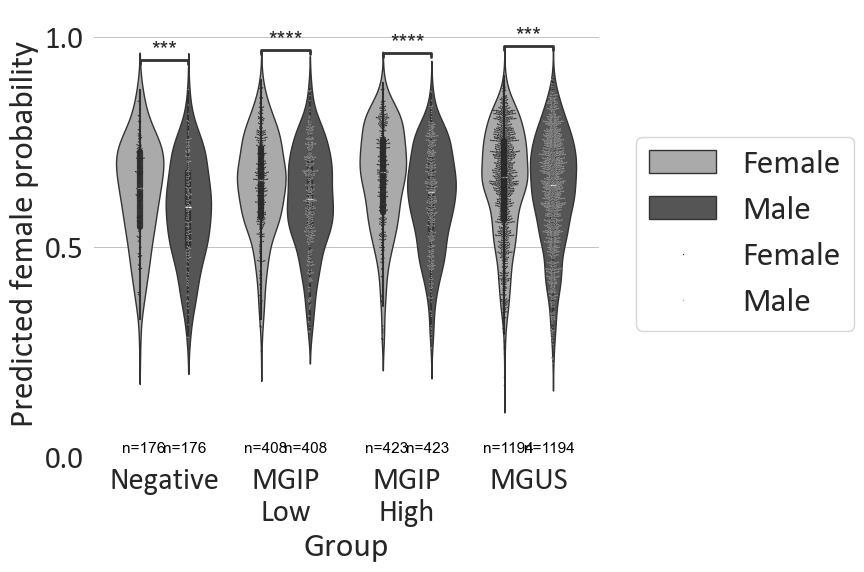

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MGIP
Low_Female vs. MGIP
Low_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:4.245e-05 U_stat=9.701e+04
Negative_Female vs. Negative_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:1.500e-03 U_stat=1.852e+04
MGIP
High_Female vs. MGIP
High_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:2.887e-06 U_stat=1.061e+05
MGUS_Female vs. MGUS_Male: Mann-Whitney-Wilcoxon test two-sided, P_val:9.359e-03 U_stat=7.566e+05


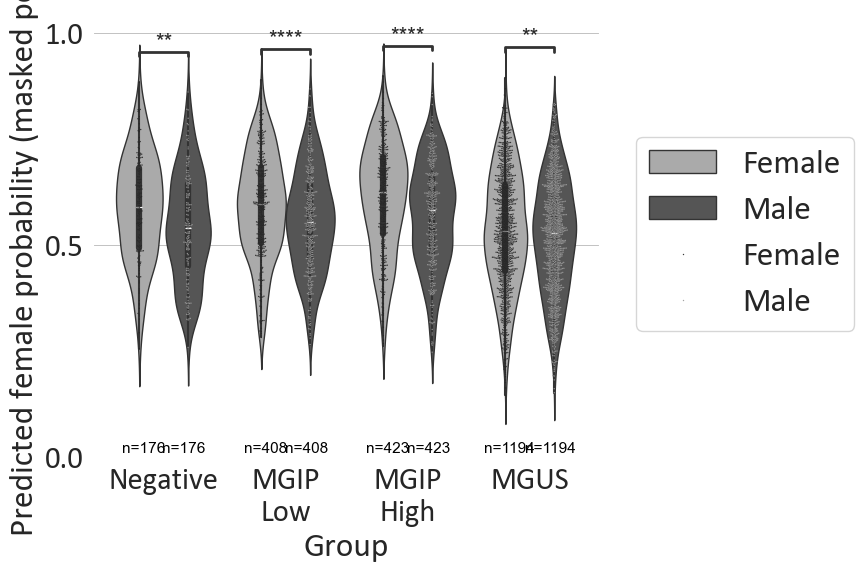

In [17]:
boxplot_predicted_quantative_versus_gt_class(balanced_df=balanced_df, PREDS_COLNAME=PREDS_COLNAME,
                                             peak_method_ticks=peak_method_ticks,
                                             ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
                                             placeholder_dict=placeholder_dict,
                                             ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                             groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                             peak_method_2_label=peak_method_2_label,
                                             separate_mgs_into_hue=True,
                                             swarmsize=1)

Similarily, we can plot the score predicted for patients regardless of their monoclonal gammopathy status

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Female vs. Male: Mann-Whitney-Wilcoxon test two-sided, P_val:3.464e-14 U_stat=2.742e+06


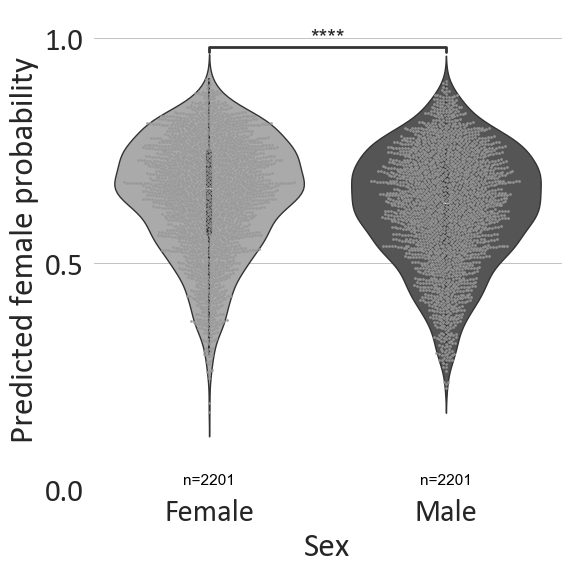

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Female vs. Male: Mann-Whitney-Wilcoxon test two-sided, P_val:1.541e-10 U_stat=2.692e+06


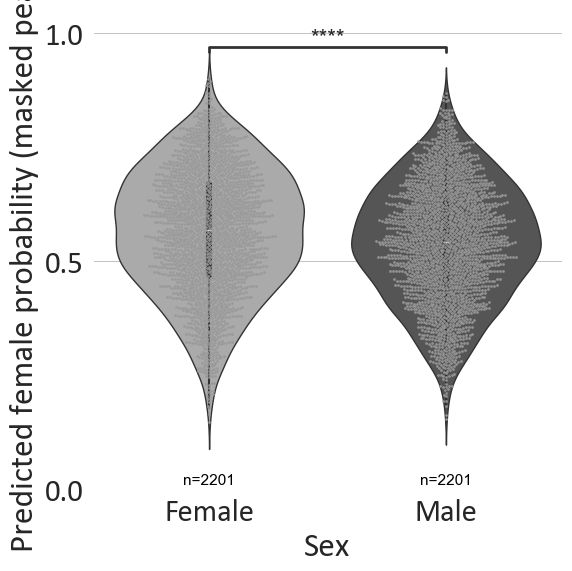

In [18]:
boxplot_predicted_quantative_versus_gt_class(balanced_df=balanced_df, PREDS_COLNAME=PREDS_COLNAME,
                                             peak_method_ticks=peak_method_ticks,
                                             ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
                                             placeholder_dict=placeholder_dict,
                                             ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                             groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                             peak_method_2_label=peak_method_2_label,
                                             separate_mgs_into_hue=False,
                                             swarmsize=2)

Then, using the balanced dataset, we can check the ROC AUC of female probability predicted by the model according to ground truth sex

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)


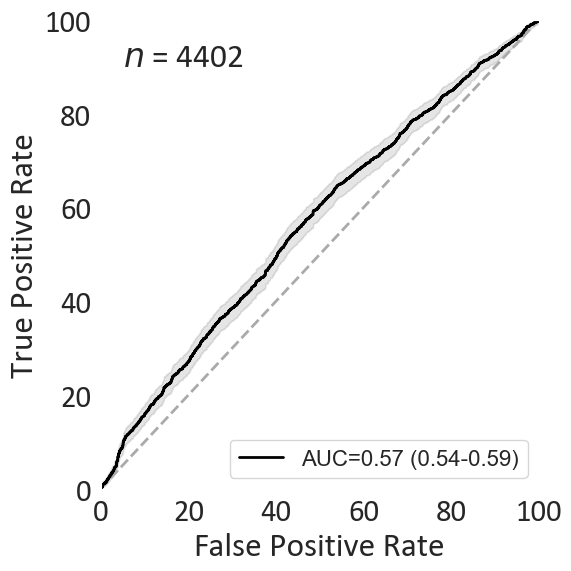

In [19]:
peak_method = PREDS_COLNAME
plt.figure(figsize=(pp_size, pp_size))
plot_roc(y=balanced_df[TRUES_COLNAME], y_=balanced_df[peak_method], display_n=True, confidence_level=.99)
plt.show()

Same, when peaks are masked from the model's input

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)


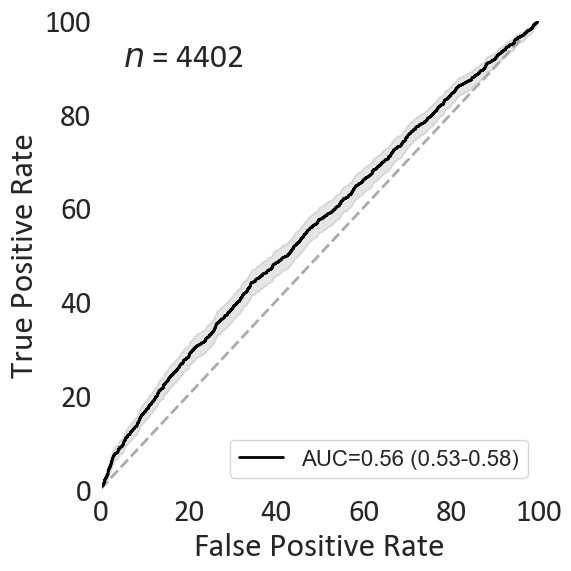

In [20]:
peak_method = PREDS_COLNAME + " (peaks dropped out)"
plt.figure(figsize=(pp_size, pp_size))
plot_roc(y=balanced_df[TRUES_COLNAME], y_=balanced_df[peak_method], display_n=True, confidence_level=.99)
plt.show()

Then separate patients according to their MG status

This is **Supplementary Figure S10**

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_f

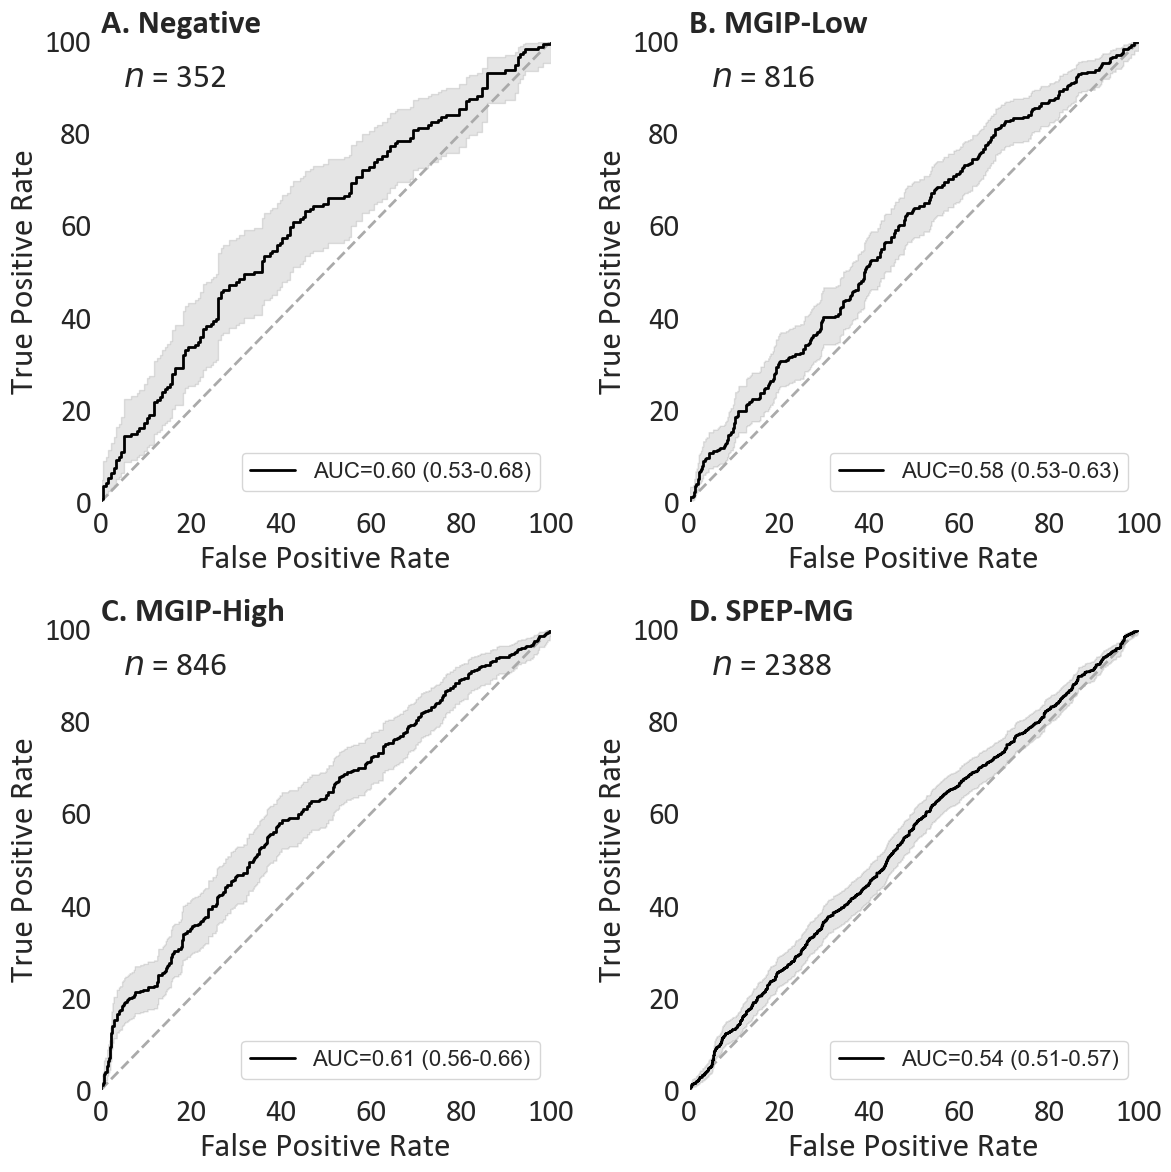

In [21]:
peak_method = PREDS_COLNAME
plt.figure(figsize=(pp_size * 2, pp_size * 2))
for k, group in enumerate(["Negative", "MGIP-Low", "MGIP-High", "MGUS"]):
    plt.subplot(2, 2, k + 1)
    if (balanced_df.Group == group).any():
        plot_roc(y=balanced_df[balanced_df.Group == group][TRUES_COLNAME],
                 y_=balanced_df[balanced_df.Group == group][peak_method],
                 suptitle="ABCD"[k] + ". " + ("SPEP-MG" if group == "MGUS" else group),
                 display_n=True, confidence_level=.99)
plt.show()

Same, using the spectra with masked peaks

C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_3408\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_f

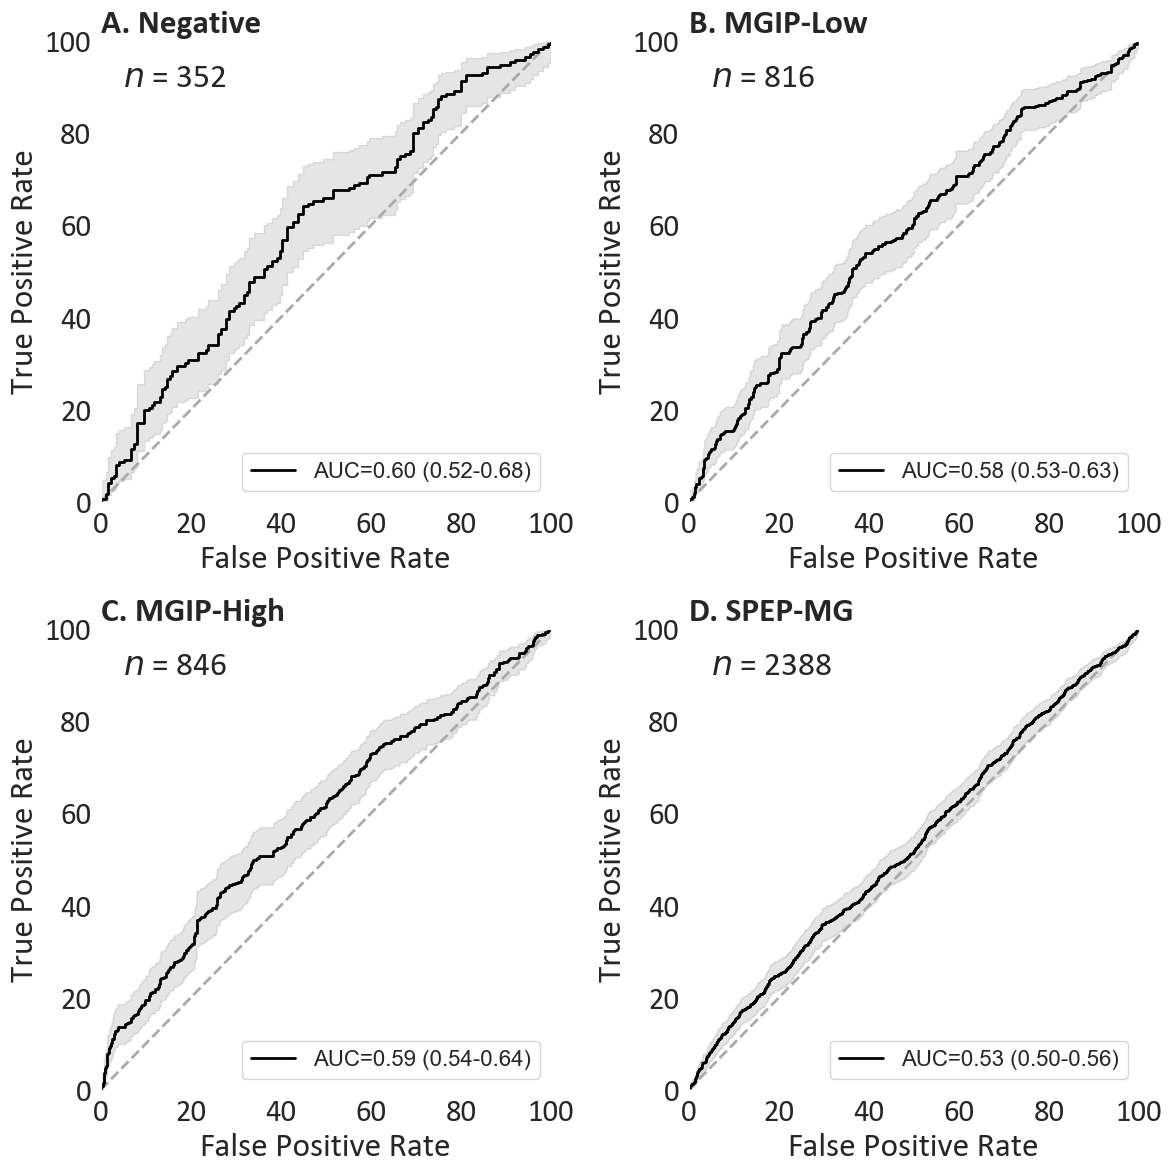

In [22]:
peak_method = PREDS_COLNAME + " (peaks dropped out)"
plt.figure(figsize=(pp_size * 2, pp_size * 2))
for k, group in enumerate(["Negative", "MGIP-Low", "MGIP-High", "MGUS"]):
    plt.subplot(2, 2, k + 1)
    if (balanced_df.Group == group).any():
        plot_roc(y=balanced_df[balanced_df.Group == group][TRUES_COLNAME],
                 y_=balanced_df[balanced_df.Group == group][peak_method],
                 suptitle="ABCD"[k] + ". " + ("SPEP-MG" if group == "MGUS" else group),
                 display_n=True, confidence_level=.99)
plt.show()